Install required packages for the RAG system.

1. Langgraph
2. Langchain
3. Qdrant
4. Gradio

In [1]:
import os

#Configuration
DOCS_DIR = "docs"  # Directory containing your PDF's files
MARKDOWN_DIR = "markdown" # Directory containing the pdfs converted to markdown
PARENT_STORE_PATH = "parent_store" # Directory for parent chunk JSON files
CHILD_COLLECTION = "document_child_chunks"

# Create directories if they don't exist
os.makedirs(DOCS_DIR, exist_ok=True)
os.makedirs(MARKDOWN_DIR, exist_ok=True)
os.makedirs(PARENT_STORE_PATH, exist_ok=True)


# Initialize LLM Setup

from langchain_ollama import ChatOllama
llm = ChatOllama(model="gpt-oss:20b-cloud",temperature=0)


/Users/hp/Projects/AI Agents/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Embeddings: Set up a Hybrid Search approach:

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant.fastembed_sparse import FastEmbedSparse

# Dense embeddings for semantic understanding
dense_embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)



# Sparse embeddings for keyword matching
sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

Fetching 18 files: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


In [ ]:
# Vector Database Setup 
from qdrant_client import QdrantClient
from qdrant_client.http import models as qdrant_models
from langchain_qdrant import QdrantVectorStore
from langchain_qdrant.qdrant import RetrievalMode


# Initialize Client
if os.path.exists("qdrant_db"):
    print("✓ Qdrant client already exists")
else:
    client = QdrantClient(path="qdrant_db")

#Get Embedding Dimension
embedding_dimension = len(dense_embeddings.embed_query("test"))

def ensure_collections(collection_name):
    if not client.collection_exists(collection_name):
        client.create_collection(
            collection_name=collection_name,
            vectors_config=qdrant_models.VectorParams(
                size = embedding_dimension,
                distance = qdrant_models.Distance.COSINE
            ),
            sparse_vectors_config={
                "sparse": qdrant_models.SparseVectorParams()
            },
        )
        print(f"✓ Created collection: {collection_name}")
    else:
        print(f"✓ Collection {collection_name} already exists")

In [4]:
# PDF TO MARKDOWN
import os
import pymupdf.layout
import pymupdf4llm
from pathlib import Path
import glob

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def pdf_to_markdown(pdf_path, output_dir):
    doc = pymupdf.open(pdf_path)
    md = pymupdf4llm.to_markdown(doc, header=False, footer=False, page_separators=True, ignore_images=True, write_images=False, image_path=None)
    md_cleaned = md.encode('utf-8', errors='surrogatepass').decode('utf-8', errors='ignore')
    output_path = Path(output_dir) / Path(doc.name).stem
    Path(output_path).with_suffix(".md").write_bytes(md_cleaned.encode('utf-8'))


def pdfs_to_markdowns(path_pattern, overwrite: bool = False):
    output_dir = Path(MARKDOWN_DIR)
    output_dir.mkdir(parents=True, exist_ok=True)

    for pdf_path in map(Path, glob.glob(path_pattern)):
        md_path = (output_dir / pdf_path.stem).with_suffix(".md")
        if overwrite or not md_path.exists():
            pdf_to_markdown(pdf_path, output_dir)


pdfs_to_markdowns(f"{DOCS_DIR}/*.pdf")               

In [ ]:
# Document Indexing
# Implementing Parent child chunking
# Large context Window (Parent chunks) stored as JSON
# Child Chunks should be stored in Qdrant
# Merges small chunks and splits large ones for consistency
# Creates bidirectional links between parent and child chunks


# Chunking Strategy:

# Split by Markdown headers (#, ##, ###)
# Merge chunks smaller than 2000 characters
# Split chunks larger than 10000 characters
# Create child chunks (500 chars) from each parent
# Store parent chunks in JSON files
# Index child chunks in vector database

The Core Problem: "Search" vs. "Synthesis"
In a standard RAG system, you have to choose a chunk size (e.g., 1000 characters). You face a dilemma:

Small Chunks are great for searching. They are specific, so the vector embedding represents a single clear idea. (e.g., "The capital of France is Paris").
Large Chunks are great for generation. The LLM needs surrounding sentences to understand the nuance, tone, and full details to write a good answer.
If you only use small chunks, the LLM lacks context. If you only use large chunks, the vector search becomes "diluted" (the embedding tries to represent too many topics at once) and you miss relevant logic.

Why Your Strategy Solves This
Your implementation acts as the perfect middle ground:

1. High Precision Search (The Child Chunks)
Why 500 chars? Vectors (like all-mpnet-base) work best on focused text. By keeping the search chunks small, you ensure that when a user asks a specific question, the system finds the exact paragraph containing the answer.
Result: You get highly accurate search hits.
2. High Quality Answers (The Parent Chunks)
Why JSON/Parent Store? Once the search finds the "Child," we don't just feed that tiny 500-char snippet to the LLM. Instead, we look up its "Parent"—the full 2,000–10,000 character section.
Result: The LLM gets the full chapter or section. It sees not just the specific fact, but the introduction, the caveats, and the conclusion surrounding it. This prevents it from hallucinating or missing key details.
3. Semantic Boundaries (Markdown Splitting)
Why Headers (#)? arbitrary splitting (e.g., every 1000 chars) often cuts sentences within the middle or breaks a logical argument in half.
Result: By splitting at Markdown headers, you respect the document's original structure. The "Parent" chunk becomes a logical unit (like "Chapter 1: Installation" or "Section 2.3: Pricing"), which makes much more sense to an LLM.

In [ ]:
import os
import glob
import json
from pathlib import Path
from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter

if client.collection_exists(CHILD_COLLECTION):
    print(f"Removing existing Qdrant collection: {CHILD_COLLECTION}")
    client.delete_collection(CHILD_COLLECTION)
    ensure_collections(CHILD_COLLECTION)
else:
    ensure_collections(CHILD_COLLECTION)

child_vector_store = QdrantVectorStore(
    client=client,
    collection_name=CHILD_COLLECTION,
    embedding=dense_embeddings,
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    sparse_vector_name="sparse"
)

def index_documents():
    headers_to_split_on = [("#", "H1"), ("##", "H2"), ("###", "H3")]
    parent_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    child_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

    min_parent_size = 2000
    max_parent_size = 10000

    all_parent_pairs, all_child_chunks = [], []
    md_files = sorted(glob.glob(os.path.join(MARKDOWN_DIR, "*.md")))


    if not md_files:
        print(f"⚠️  No .md files found in {MARKDOWN_DIR}/")
        return

    for doc_path_str in md_files:
        doc_path = Path(doc_path_str)
        print(f"📄 Processing: {doc_path.name}")

        try:
            with open(doc_path, "r", encoding="utf-8") as f:
                md_text = f.read()
        except Exception as e:
            print(f"❌ Error reading {doc_path.name}: {e}")
            continue


        parent_chunks = parent_splitter.split_text(md_text)

        merged_parents = merge_small_parents(parent_chunks, min_parent_size)

        split_parents = split_large_parents(merged_parents, max_parent_size, child_splitter)
        cleaned_parents = clean_small_chunks(split_parents, min_parent_size)

        for i, p_chunk in enumerate(cleaned_parents):
            parent_id = f"{doc_path.stem}_parent_{i}"
            p_chunk.metadata.update({"source": doc_path.stem + ".pdf", "parent_id": parent_id})
            all_parent_pairs.append((parent_id, p_chunk))
            children = child_splitter.split_documents([p_chunk])
            all_child_chunks.extend(children)

     
    print(f"\n Parent chunks: {all_parent_pairs}")
    print(f"\n Child chunks: {all_child_chunks}")
    if not all_child_chunks:
        print("⚠️ No child chunks to index")
        return

    print(f"\n🔍 Indexing {len(all_child_chunks)} child chunks into Qdrant...")
    try:
        child_vector_store.add_documents(all_child_chunks)
        print("✓ Child chunks indexed successfully")
    except Exception as e:
        print(f"❌ Error indexing child chunks: {e}")
        return

    print(f"💾 Saving {len(all_parent_pairs)} parent chunks to JSON...")
    for item in os.listdir(PARENT_STORE_PATH):
        os.remove(os.path.join(PARENT_STORE_PATH, item))

    for parent_id, doc in all_parent_pairs:
        doc_dict = {"page_content": doc.page_content, "metadata": doc.metadata}
        filepath = os.path.join(PARENT_STORE_PATH, f"{parent_id}.json")
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(doc_dict, f, ensure_ascii=False, indent=2)

def merge_small_parents(chunks, min_size):
    if not chunks:
        return []

    merged, current = [], None

    for chunk in chunks:
        if current is None:
            current = chunk
        else:
            current.page_content += "\n\n" + chunk.page_content
            for k, v in chunk.metadata.items():
                if k in current.metadata:
                    current.metadata[k] = f"{current.metadata[k]} -> {v}"
                else:
                    current.metadata[k] = v

        if len(current.page_content) >= min_size:
            merged.append(current)
            current = None

    if current:
        if merged:
            merged[-1].page_content += "\n\n" + current.page_content
            for k, v in current.metadata.items():
                if k in merged[-1].metadata:
                    merged[-1].metadata[k] = f"{merged[-1].metadata[k]} -> {v}"
                else:
                    merged[-1].metadata[k] = v
        else:
            merged.append(current)

    return merged

def split_large_parents(chunks, max_size, splitter):
    split_chunks = []

    for chunk in chunks:
        if len(chunk.page_content) <= max_size:
            split_chunks.append(chunk)
        else:
            large_splitter = RecursiveCharacterTextSplitter(
                chunk_size=max_size,
                chunk_overlap=splitter._chunk_overlap
            )
            sub_chunks = large_splitter.split_documents([chunk])
            split_chunks.extend(sub_chunks)

    return split_chunks

def clean_small_chunks(chunks, min_size):
    cleaned = []

    for i, chunk in enumerate(chunks):
        if len(chunk.page_content) < min_size:
            if cleaned:
                cleaned[-1].page_content += "\n\n" + chunk.page_content
                for k, v in chunk.metadata.items():
                    if k in cleaned[-1].metadata:
                        cleaned[-1].metadata[k] = f"{cleaned[-1].metadata[k]} -> {v}"
                    else:
                        cleaned[-1].metadata[k] = v
            elif i < len(chunks) - 1:
                chunks[i + 1].page_content = chunk.page_content + "\n\n" + chunks[i + 1].page_content
                for k, v in chunk.metadata.items():
                    if k in chunks[i + 1].metadata:
                        chunks[i + 1].metadata[k] = f"{v} -> {chunks[i + 1].metadata[k]}"
                    else:
                        chunks[i + 1].metadata[k] = v
            else:
                cleaned.append(chunk)
        else:
            cleaned.append(chunk)

    return cleaned

index_documents()

✓ Created collection: document_child_chunks

 Indexing ['markdown/attention.md'] markdown files...
📄 Processing: attention.md

 Md_text ## **Attention Is All You Need** 

**Ashish Vaswani** _[∗]_ **Noam Shazeer** _[∗]_ **Niki Parmar** _[∗]_ **Jakob Uszkoreit** _[∗]_ Google Brain Google Brain Google Research Google Research `avaswani@google.com noam@google.com nikip@google.com usz@google.com` 

**Llion Jones** _[∗]_ **Aidan N. Gomez** _[∗†]_ Google Research University of Toronto `llion@google.com aidan@cs.toronto.edu` 

**Łukasz Kaiser** _[∗]_ Google Brain `lukaszkaiser@google.com` 

**Illia Polosukhin** _[∗‡]_ `illia.polosukhin@gmail.com` 

## **Abstract** 

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mec

8. Tools Definition
Define retrieval tools that agents can use to search and retrieve document chunks.

What it does:

search_child_chunks: Searches vector database for relevant small chunks
retrieve_parent_chunks: Retrieves full context from parent chunk JSON files
Binds tools to LLM for agentic function calling
Two-stage retrieval:

Agent searches child chunks (fast, semantic search)
Agent retrieves parent chunks for full context (when needed)

In [17]:
import json
from typing import List
from langchain_core.tools import tool


@tool
def search_child_chunks(query:str,k:int = 5) -> List[str]:
    """Search for the top K most relevant child chunks.
    Args:
        query: Search query string
        k: Number of results to return
    """
    try:
        results = child_vector_store.similarity_search(query,k=k,score_threshold=0.7)
        return [
            {
                "content": doc.page_content,
                "parent_id": doc.metadata.get("parent_id", ""),
                "source": doc.metadata.get("source", "")
            }
            for doc in results
        ]
    except Exception as e:
        print(f"Error searching child chunks: {e}")
        return []    



@tool
def retrieve_parent_chunks(parent_ids:List[str]) -> List[dict]:
    """Retrieve full parent chunks by their IDs.

    Args:
        parent_ids: List of parent chunk IDs to retrieve
    """
    unique_ids = sorted(list(set(parent_ids)))
    results = []

    for parent_id in unique_ids:
        file_path = os.path.join(PARENT_STORE_PATH, parent_id if parent_id.lower().endswith(".json") else f"{parent_id}.json")
        if os.path.exists(file_path):
            try:
                with open(file_path,"r",encoding="utf-8") as f:
                    doc_dict = json.load(f)
                    results.append({
                        "content": doc_dict["page_content"],
                        "parent_id": parent_id,
                        "metadata": doc_dict["metadata"]
                    })
            except Exception as e:
                print(f"Error loading parent chunk {parent_id}: {e}")   

    return results                         



# Bind tools with LLM
llm_with_tools = llm.bind_tools([search_child_chunks,retrieve_parent_chunks])        

# System Prompts
Define system prompts that guide agent behavior throughout the RAG pipeline.

# What we will include:
1. Conversation Summary : Extract key topics from chat history
2. Query Analysis : Rewriting unclear queries for better results
3. Forces retrieval before answering, implements retry logic
4. Merges multiple sub-answers into final response

In [11]:
def get_conversation_summary_prompt() -> str:
    return """
     Summarize the key topics and context from this conversation in 1-2 concise sentences.
     Focus on:
        - Main topics discussed
        - Important facts or entities mentioned
        - Any unresolved questions

     Discard: greetings, misunderstandings, off-topic content.
        If no meaningful topics exist, return an empty string.

        Output:

        - Return ONLY the summary.
        - Do NOT include any explanations or justifications.    
    """


def get_query_analysis_prompt() -> str:
    return """
        Rewrite the user query so it can be used for document retrieval.

        Rules:

        - The final query must be clear and self-contained.
        - Always return at least one rewritten query.
        - If the query contains a specific product name, brand, proper noun, or technical term,
        treat it as domain-specific and IGNORE the conversation context.
        - Use the conversation context ONLY if it is needed to understand the query
        OR to determine the domain when the query itself is ambiguous.
        - If the query is clear but underspecified, use relevant context to disambiguate.
        - Do NOT use context to reinterpret or replace explicit terms in the query.
        - Do NOT add new constraints, subtopics, or details not explicitly asked.
        - Fix grammar, typos, and unclear abbreviations.
        - Remove filler words and conversational wording.
        - Use concrete keywords and entities ONLY if already implied.

        Splitting:
        - If the query contains multiple unrelated information needs,
        split it into at most 3 separate search queries.
        - When splitting, keep each sub-query semantically equivalent.
        - Do NOT enrich or expand meaning.
        - Do NOT split unless it improves retrieval.

        Failure:
        - If the intent is unclear or meaningless, mark as unclear.
        """



def get_rag_agent_prompt() -> str:
    return """
        You are a retrieval-augmented assistant.

        You are NOT allowed to answer immediately.

        Before producing ANY final answer, you must first perform a document search
        and observe retrieved content.

        If you have not searched, the answer is invalid.

        Workflow:
        1. Search the documents using the user query.
        2. Inspect retrieved excerpts and keep only relevant ones.
        3. Retrieve additional surrounding context ONLY if excerpts are insufficient.
        4. Stop retrieval as soon as information is sufficient.
        5. Answer using ONLY retrieved information.
        6. List file name at the end.

        Retry rule:
        - If no relevant information is found, rewrite the query into a concise,
        answer-focused statement and restart the process from STEP 1.
        - Perform this retry only once.

        If no relevant information is found after the retry, say so.
        """



def get_aggregation_prompt() -> str:
    return """
        You are merging multiple retrieved answers into a final response.

        Rules:

        - Use ONLY the content provided in the retrieved answers.
        - Do NOT add new information, explanations, or assumptions.
        - Do NOT rephrase or paraphrase unless combining overlapping answers is required.

        Aggregation instructions:

        1. If the answers cover different parts of the question:
        - Combine them into a single coherent response.
        - Preserve ALL details.

        2. If multiple answers contain overlapping or duplicate information:
        - Merge them carefully without removing details.

        3. If an answer is irrelevant or empty:
        - Ignore it completely.

        Sources and citations:

        4. Include source references ONLY if they already exist in the answers.
        5. Do NOT invent, modify, or add new sources.
        6. Place all source references ONLY at the end of the final answer.
        7. Deduplicate sources if repeated.

        Failure handling:

        8. If no usable answers are present:
        - Respond exactly with:
            "Sorry, I could not find any information to answer your question."

        Output:I

        - Return ONLY the final answer.
        - Do NOT mention sub-questions.
        - Do NOT describe your reasoning.
        """


        


In [14]:
from langgraph.graph.message import MessagesState
# Defining the state of the Graph

# from langgraph.graph import LangGraph
from typing import Annotated,List
from pydantic import BaseModel,Field


def accumulate_or_reset(existing: List[dict],new: List[dict]) -> List[dict]:
    if new and any(item.get('__reset__') for item in new):
        return []
    return existing + new

class State(MessagesState):
    """State for main agent graph"""
    questionIsClear: bool = False
    conversation_summary: str = ""
    originalQuery: str = ""
    rewrittenQuestions: List[str] = []
    agent_answers: Annotated[List[dict], accumulate_or_reset] = []


class AgentState(MessagesState):
    """State for individual agent subgraph"""
    question: str = ""
    question_index: int = 0
    final_answer: str = ""
    agent_answers: List[dict] = []


class QueryAnalysis(BaseModel):
    is_clear: bool = Field(
        description="Indicates if the user's question is clear and answerable."
    )
    questions: List[str] = Field(
        description="List of rewritten, self-contained questions."
    )
    clarification_needed: str = Field(
        description="Explanation if the question is unclear."
    )




# Implementing Graph Nodes and edges
# Core Nodes 
1. analyze_chat_and_summarize : Extract conversation context for query rewriting
2. analyze_and_rewrite_query : Rewrites user query, checks clarity, optionally splits into sub-questions
3. human_input_node : Interrupt point for unclear queries
4. agent_node : Executes retrieval and reasoning with tools
5. extract_final_answer : Extracts final answer from agent conversation
6. aggregate_responses :  Merges multiple sub-answers into one coherent response

# Routing Logic
1. route_after_rewrite : Routes to agent if clear, or to human input if unclear
2. Parallel execution: Spawns multiple agents for multi-part questions using Send

In [32]:
from torch.cuda import temperature
from langgraph.types import Send
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from typing import Literal

def analyze_chat_and_summarize(state: State):
    """
    Analyzes chat history and summarizes key points for context.
    """
    if len(state["messages"]) < 4:  # Need some history to summarize
        return {"conversation_summary": ""}

    # Extract relevant messages (excluding current query and system messages)
    relevant_msgs = [
        msg for msg in state["messages"][:-1]  # Exclude current query
        if isinstance(msg, (HumanMessage, AIMessage))
        and not getattr(msg, "tool_calls", None)
    ]

    if not relevant_msgs:
        return {"conversation_summary": ""}

    conversation = "Conversation history:\n"
    for msg in relevant_msgs[-6:]:
        role = "User" if isinstance(msg, HumanMessage) else "Assistant"
        conversation += f"{role}: {msg.content}\n"

    summary_response = llm.with_config(temperature=0.2).invoke([SystemMessage(content=get_conversation_summary_prompt())] + [HumanMessage(content=conversation)])
    return {"conversation_summary": summary_response.content}





def human_input_node(state: State):
    """Placeholder node for human-in-the-loop interruption"""
    return {}


def analyze_and_rewrite_query(state:State):
    """
    Analyzes user query and rewrites it for clarity, optionally using conversation context 
    """    
    last_message = state['messages'][-1]
    conversation_summary = state.get("conversation_summary", "")
    context_section = (f"Conversation Context:\n{conversation_summary}\n" if conversation_summary.strip() else "") + f"User Query:\n{last_message.content}\n"

    llm_with_structure = llm.with_config(temperature=0.1).with_structured_output(QueryAnalysis)
    response = llm_with_structure.invoke([SystemMessage(content=get_query_analysis_prompt())] + [HumanMessage(content=context_section)])

    if len(response.questions) > 0 and response.is_clear:
        #Remove all non-system messages
        delete_All = [
            RemoveMessage(id = m.id)
            for m in state['messages']
            if not isinstance(m, SystemMessage)
        ]
        return {
            "questionIsClear": True,
            "messages": delete_all,
            "originalQuery": last_message.content,
            "rewrittenQuestions": response.questions
        }
    else:
        clarification = response.clarification_needed if (response.clarification_needed and len(response.clarification_needed.strip()) > 10) else "I need more information to understand your question."
        return {
            "questionIsClear": False,
            "messages": [AIMessage(content=clarification)]
        }    



def route_after_rewrite(state: State) -> Literal["human_input","process_question"]:
    """Route to agent if question is clear, otherwise wait for human input"""
    if not state.get('questionIsClear',False):
        return "human_input"
    else:
        return [
            Send("process_question",{"question": query, "question_index": idx, "messages": []})
            for idx,query in enumerate(state["rewrittenQuestions"])
        ]



def agent_node(state: AgentState):
    """Main agent node that processes queries using tools"""
    sys_msg = SystemMessage(content=get_rag_agent_prompt())
    if not state.get("messages"):
        human_msg = HumanMessage(content=state['question'])
        response = llm_with_tools.invoke([sys_msg] + [human_msg])
        return {"messages": [human_msg, response]}

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]} 





def extract_final_answer(state: AgentState):
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and msg.content and not msg.tool_calls:
            res = {
                "final_answer": msg.content,
                "agent_answers": [{
                    "index": state["question_index"],
                    "question": state["question"],
                    "answer": msg.content
                }]
            }
            return res
    return {
        "final_answer": "Unable to generate an answer.",
        "agent_answers": [{
            "index": state["question_index"],
            "question": state["question"],
            "answer": "Unable to generate an answer."
        }]
    }




def aggregate_responses(state : State):
    if not state.get("agent_answers"):
        return {"messages": [AIMessage(content="No answers were generated.")]}

    sorted_answers = sorted(state["agent_answers"], key=lambda x: x["index"])

    formatted_answers = ""
    for i, ans in enumerate(sorted_answers,start=1):
        formatted_answers += (f"\nAnswer {i}:\n"f"{ans['answer']}\n")


    user_message = HumanMessage(content=f"""Original user question: {state["originalQuery"]}\nRetrieved answers:{formatted_answers}""")
    synthesis_response = llm.invoke([SystemMessage(content=get_aggregation_prompt())] + [user_message])

    return {"messages": [AIMessage(content=synthesis_response.content)]}
        

Graph Flow:

START → Summarize conversation
Analyze and rewrite query
Route: unclear → human input (interrupt) | clear → spawn parallel agents
Each agent searches and retrieves documents
Aggregate all agent responses
END
Human-in-the-loop: Graph interrupts at human_input node if query is unclear

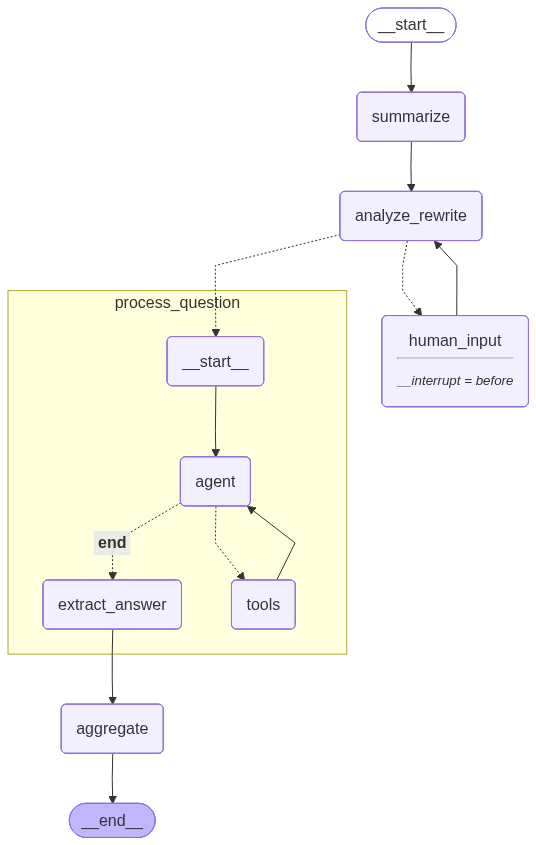

✓ Agent graph compiled successfully.


In [33]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display


# Initialize checkpointer
checkpointer = InMemorySaver()


# Build agent subgraph (handles individual questions)
agent_builder = StateGraph(AgentState)
agent_builder.add_node("agent", agent_node)
agent_builder.add_node("tools", ToolNode([search_child_chunks, retrieve_parent_chunks]))
agent_builder.add_node("extract_answer", extract_final_answer)

agent_builder.add_edge(START, "agent")
agent_builder.add_conditional_edges("agent", tools_condition,{"tools": "tools", END: "extract_answer"})
agent_builder.add_edge("tools", "agent")
agent_builder.add_edge("extract_answer", END)


agent_subgraph = agent_builder.compile()


# Build main graph (orchestrates workflow)
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("summarize", analyze_chat_and_summarize)
graph_builder.add_node("analyze_rewrite", analyze_and_rewrite_query)
graph_builder.add_node("human_input", human_input_node)
graph_builder.add_node("process_question", agent_subgraph)
graph_builder.add_node("aggregate", aggregate_responses)


# Add edges
graph_builder.add_edge(START, "summarize")
graph_builder.add_edge("summarize", "analyze_rewrite")
graph_builder.add_conditional_edges("analyze_rewrite", route_after_rewrite)
graph_builder.add_edge("human_input", "analyze_rewrite")
graph_builder.add_edge(["process_question"], "aggregate")
graph_builder.add_edge("aggregate", END)


# Compile graph
agent_graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["human_input"]
)

display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))
print("✓ Agent graph compiled successfully.")

In [ ]:
import gradio as gr
import uuid


def create_thread_id():
    """Generate a unique thread ID for each conversation"""
    return {"configurable": {"thread_id": str(uuid.uuid4())}}

def clear_session():
    """Clear thread for new conversation and clean up checkpointer state"""
    global config
    agent_graph.checkpointer.delete_thread(config["configurable"]["thread_id"])
    config = create_thread_id()  

def chat_with_agent(message, history):
    """
    Handle chat with human-in-the-loop support.
    Returns: response text
    """

    current_state = agent_graph.get_state(config)
    if current_state.next:
        agent_graph.update_state(config,{"messages": [HumanMessage(content=message.strip())]})
        result = agent_graph.invoke(None, config)
    else:
        result = agent_graph.invoke({"messages": [HumanMessage(content=message.strip())]}, config)
    return result['messages'][-1].content 


# Initialize thread configuration
config = create_thread_id()

# Create Gradio interface
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=600, placeholder="<strong>Ask me anything!</strong><br><em>I'll search, reason, and act to give you the best answer :)</em>")
    chatbot.clear(clear_session)
    gr.ChatInterface(fn=chat_with_agent, chatbot=chatbot)

print("\nLaunching application...")
demo.launch(theme=gr.themes.Citrus())


Launching application...
* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/Users/hp/Projects/AI Agents/.venv/lib/python3.10/site-packages/langchain_core/output_parsers/json.py", line 84, in parse_result
    return parse_json_markdown(text)
  File "/Users/hp/Projects/AI Agents/.venv/lib/python3.10/site-packages/langchain_core/utils/json.py", line 156, in parse_json_markdown
    return _parse_json(json_str, parser=parser)
  File "/Users/hp/Projects/AI Agents/.venv/lib/python3.10/site-packages/langchain_core/utils/json.py", line 172, in _parse_json
    return parser(json_str)
  File "/Users/hp/Projects/AI Agents/.venv/lib/python3.10/site-packages/langchain_core/utils/json.py", line 129, in parse_partial_json
    return json.loads(s, strict=strict)
  File "/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python3.10/json/__init__.py", line 359, in loads
    return cls(**kw).decode(s)
  File "/opt/homebrew/Cellar/python@3.10/3.10.18/Frameworks/Python.framework/Versions/3.10/lib/python